## NBA Statistics During Golden State Warriors (GSW) Championship Run Project - Model Prediction

### Introduction:

This section of the project utilizes the findings from the exploratory analysis section of the project to build a predictive model. The model will attempt to predict season performance (measured in wins) of NBA teams and thereby determine whether a team is able to make it into the playoffs.

Imported libraries are Pandas, Numpy, Matplotlib, Seaborn, Scikit-Learn, Statsmodels along with select associated modules; in addition, the copy and plotting modules, and imgkit wrapper have been imported.

In [1]:
# Import libraries to perform split on data and linear regression model fitting
import pandas as pd # library for data manipulation and analysis
import numpy as np # library adding support for large arrays and matrices, including mathematical functions
import matplotlib.pyplot as plt # library for general plotting of data
import matplotlib.patches as mpatches # module to manipulate legend in graphs
%matplotlib inline
import seaborn as sns # data visualization library based on matplotlib; addtional features for attractive visualizations
import copy # module for deep copy as needed
from pandas.plotting import table as tb # module for plotting table

# Machine learning algorithms and stats libraries 
from sklearn.model_selection import train_test_split # module to split data into train & test sets
from sklearn.linear_model import LinearRegression # module to perform LinearRegression model fitting on data
from sklearn.preprocessing import StandardScaler # module to perform preprocessing of data; scale data
from sklearn import metrics # module to perform calculations for metrics of model
import statsmodels.api as sm # stats library tool
import statsmodels.formula.api as smf # module with R-style formulas

In [2]:
# read in csv file to view data in pandas
all_teams_df = pd.read_csv("all_teams_df_stats.csv")

In [3]:
# double check if any data is null
print(all_teams_df.isnull().any())

Season     False
Tm         False
W          False
Age        False
3P         False
3P%        False
DRB        False
AST        False
BLK        False
AstTOVr    False
TS%        False
dtype: bool


In [4]:
# view dataframe head
all_teams_df.head(10)

,Season,Tm,W,Age,3P,3P%,DRB,AST,BLK,AstTOVr,TS%
0,2019,ATL,29,25.1,1067,0.352,2825,2118,419,1.516106,0.555335
1,2018,ATL,24,25.4,917,0.360,2693,1946,348,1.525078,0.547285
2,2017,ATL,43,27.9,729,0.341,2793,1938,397,1.497682,0.541192
3,2016,ATL,48,28.2,815,0.350,2772,2100,486,1.712887,0.551629
4,2015,ATL,60,27.8,818,0.380,2611,2111,380,1.808912,0.563425
5,2019,BOS,49,25.7,1032,0.365,2849,2155,435,2.048479,0.567060
6,2018,BOS,55,24.7,939,0.377,2878,1842,373,1.603133,0.552276
7,2017,BOS,53,25.9,985,0.359,2698,2069,340,1.901654,0.566643
8,2016,BOS,48,25.2,717,0.335,2733,1981,348,1.757764,0.530749
9,2015,BOS,40,25.0,660,0.327,2685,2009,294,1.773169,0.522812


The statsmodels library doesn't properly interpret features with special characters (e.g. %) and that begin with numerical values &mdash; rename column names 3P, 3P%, TS%.

In [5]:
# change column names with special characters and that begin with numerical values
all_teams_df.rename(columns={'3P':'ThreePT', '3P%':'ThreePCT', 'TS%':'TSpct'}, inplace=True)

In [6]:
# view columns
print(all_teams_df.columns)

Index(['Season', 'Tm', 'W', 'Age', 'ThreePT', 'ThreePCT', 'DRB', 'AST', 'BLK',
       'AstTOVr', 'TSpct'],
      dtype='object')


In [7]:
# create two dataframes seasons < 2019 and seasons == 2019

# dataframe to be used to fit model to train/test data
model_data = all_teams_df[all_teams_df['Season']<2019].copy(deep=True)

# dataframe to be used to see how well model predicts new "unseen" data
pred_model_data = all_teams_df[all_teams_df['Season']==2019].copy(deep=True)

**Using the Scikit-Learn train_test_split algorithm, split the model_data data frame into training and testing sets to analyze feature selection.**

In [8]:
# create X matrix & y vector data to split for training and testing
X_data = model_data[['Age', 'ThreePT', 'ThreePCT', 'DRB', 'AST', 'BLK', 'AstTOVr', 'TSpct']]
y_data = model_data['W']

In [9]:
# split data into training and testing sets for X and y values
# 70/30 split on data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=101)

Since the statistics have different magnitudes of values, standardize them using StandardScaler.

In [10]:
# standardize the X train and test sets
scaler = StandardScaler()
stand_X_train = scaler.fit_transform(X_train.values)
stand_X_test = scaler.transform(X_test.values)

In [11]:
# convert standardized X_train data array to dataframe
train_model_df = pd.DataFrame(stand_X_train, index=X_train.index, columns=['Age', 'ThreePT', 'ThreePCT', 'DRB', 'AST', 'BLK', 'AstTOVr', 'TSpct'])

# combine stand_X_train and y_train into one dataframe for feature selection analysis
train_model_df.insert(0, 'W', y_train, True)

In [12]:
# view dataframe head
train_model_df.head()

,W,Age,ThreePT,ThreePCT,DRB,AST,BLK,AstTOVr,TSpct
4,60,0.574172,0.471696,1.419029,-1.049407,1.435433,-0.375074,1.204784,0.843416
53,41,0.574172,0.866080,-0.439926,-1.137338,-0.163211,0.391873,-1.075968,0.302557
101,48,0.310329,0.885799,-0.045602,-0.521825,-0.554604,0.115772,-0.349168,-0.008067
118,23,-0.375662,-0.054150,-0.383594,0.023343,-0.824720,-1.402782,-2.101449,-0.997961
73,42,1.998922,-1.592248,-1.341237,-2.051814,-0.846770,-0.835242,-0.178177,-1.102982


In [13]:
# convert stand_X_test data array to dataframe; should have same column headings as train_model_df
test_model_df = pd.DataFrame(stand_X_test, index=X_test.index, columns=['Age', 'ThreePT', 'ThreePCT', 'DRB', 'AST', 'BLK', 'AstTOVr', 'TSpct'])

In [14]:
# view dataframe head
test_model_df.head()

,Age,ThreePT,ThreePCT,DRB,AST,BLK,AstTOVr,TSpct
17,-0.111819,0.511134,-0.214598,1.078508,0.222668,-0.221684,2.294111,0.035754
86,0.204792,-0.579995,0.123394,-1.207682,0.057291,-0.911936,1.280569,0.966751
68,-0.111819,-0.704883,-2.129885,-0.750444,-2.054022,-1.034648,-1.505732,-1.887342
27,1.312931,2.108390,1.644357,0.797131,0.040754,-1.188037,0.373666,1.650317
84,-1.114421,-1.322752,0.461386,-1.374750,0.448684,-0.022278,-0.999856,-0.523413


**Using the Statsmodels ordinary least squares (OLS) regression algorithm, evaluate which stats show significance &mdash; i.e. the relationship with wins.**

In [15]:
# fit OLS regression model to data
OLS_lm = smf.ols(formula='W ~ Age + ThreePT + ThreePCT + DRB + AST + BLK + AstTOVr + TSpct', data=train_model_df).fit()

Establish functions to return information about the ordinary least squares (OLS) model, which helps analyze the model's performance.

In [16]:
def get_ols_sum(model, fig_num):
    """
    Create and save a figure of the Ordinary Least Squares (OLS) summary.
    
    Takes an OLS model and a model number to identify the model's summary table for .png file.
    """
    # save OLS_lm summary as a figure
    plt.rc('figure', figsize=(12,7))
    plt.text(0.15,0.08, str(model.summary()), {'fontsize':75}, fontproperties='monospace')
    plt.axis('off')
    plt.tight_layout()

    # plt.savefig('OLS_lm'+str(fig_num)+'.png')

In [17]:
def get_olm_conf(model, fig_num):
    """
    Create and save a figure of the Ordinary Least Squares (OLS) confidence interval.
    
    Takes an OLS model and a model number to identify the model's confidence interval table for .png file.
    """
    # save OLS_lm confidence interval as a figure
    axt = plt.subplot(frame_on=False)
    axt.xaxis.set_visible(False)
    axt.yaxis.set_visible(False)
    OLS_conf_tb = tb(axt, model.conf_int().round(3), loc='center', bbox=[0,0,1,1])
    OLS_conf_tb.auto_set_font_size(False)
    OLS_conf_tb.set_fontsize(12)

    plt.title('Confidence Interval - OLS_lm'+str(fig_num), loc='center')

    # plt.savefig('OLS_lm_conf'+str(fig_num)+'.png')    

In [18]:
def get_ols_pval(model, fig_num):
    """
    Create and save a figure of the Ordinary Least Squares (OLS) p-values.
    
    Takes an OLS model and a model number to identify the model's p-value table for .png file.
    """
    # save OLS_lm p-value as a figure
    axp = plt.subplot(frame_on=False)
    axp.xaxis.set_visible(False)
    axp.yaxis.set_visible(False)
    OLS_pval_tb = tb(axp, model.pvalues.round(3), loc='center', bbox=[0.1,0,1,1], colLabels=['p-value'])
    OLS_pval_tb.auto_set_font_size(False)
    OLS_pval_tb.set_fontsize(12)

    # plt.savefig('OLS_lm_pval'+str(fig_num)+'.png')

In [19]:
def calc_pred_resid(model, pred_xvals, y_test_vals):
    """
    Calculate and return the Ordinary Least Squares (OLS) model's predicted values and residuals.
    
    Takes an OLS model, the x-values to predict the results of using the OLS model, and the true outcome y-test values.  
    """
    # generate predicted values using OLS model
    pred_val = model.predict(pred_xvals)

    # calculate residual (i.e. errors) values between true and predicted values
    lm_resid = y_test_vals-pred_val
    
    return pred_val, lm_resid

In [20]:
def calc_sse(resid):
    """
    Calculate and return the Sum of Squared Residuals (SSR) or Sum of Squared Errors (SSE).
    
    Takes the residual error values of the OLS model.  
    """
    # measures discrepancy between data and model's predicted values; sum of squared errors of regression model
    return sum(resid**2)

In [21]:
def calc_sst(y_train_vals, y_test_vals):
    """
    Calculate and return the Total Sum of Squares (TSS or SST).
    
    Takes the true outcome y-train values and y-test values.  
    """
    # measures discrepancy between actual test values and baseline model's predicted values (i.e. mean); sum of squared errors of baseline model
    return sum((np.mean(y_train_vals)-y_test_vals)**2)

In [22]:
def calc_rsquared(model_sse, model_sst):
    """
    Calculate and return R-squared.
    
    Takes the Sum of Squared Errors (SSE) and Total Sum of Squares (SST).  
    """
    # calculate R-squared to measure "goodness of fit"; how much variance in the response data does the model account for
    return 1-(model_sse/model_sst)

In [23]:
def calc_rmse(model_sse, y_test_vals):
    """
    Calculate and return Root Mean Squared Error (RMSE).
    
    Takes the Sum of Squared Errors (SSE) and true outcome y-test values.  
    """
    # calculate Root Mean Squared Error (RMSE) to measure standard deviation of residuals (i.e. prediction errors)
    return np.sqrt(model_sse/len(y_test_vals))

In [24]:
 def get_rsquare_rmse(model, pred_xvals, y_train_vals, y_test_vals):
    """
    Calculate and return R-squared & Root Mean Squared Error (RMSE) directly; 
    functions as combined calculation for R-squared & RMSE.
    
    Takes a Ordinary Least Squares (OLS) model, the x-values to predict the results of using the OLS model, 
    the true outcome y-train and y-test values.  
    """
    # call calc_pred_resid() function to get predicted and residual values
    predicted_vals, residual_vals = calc_pred_resid(model, pred_xvals, y_test_vals)
    
    # call calc_sse() function to get Sum of Squared Errors (SSE)
    sse = calc_sse(residual_vals)
    
    # call calc_sst() function to get Total Sum of Squares (SST)
    sst = calc_sst(y_train_vals, y_test_vals)
    
    # call calc_rsquared() function to get R-squared value
    rsquared = calc_rsquared(sse, sst)
    
    # call calc_rmse() function to get Root Mean Squared Error (RMSE)
    rmse = calc_rmse(sse, y_test_vals)
    
    return rsquared, rmse

In [25]:
# function to print the rsquared and rmse values
def show_rsquare_rmse(rsquare, rmse):
    """
    Print the R-squared & Root Mean Squared Error (RMSE) values.
    
    Takes the calculated R-squared and RMSE values.  
    """
    print('R-squared = '+str(rsquare), '\nRMSE = '+str(rmse))

Take a look at the summary of the OLS regression model.

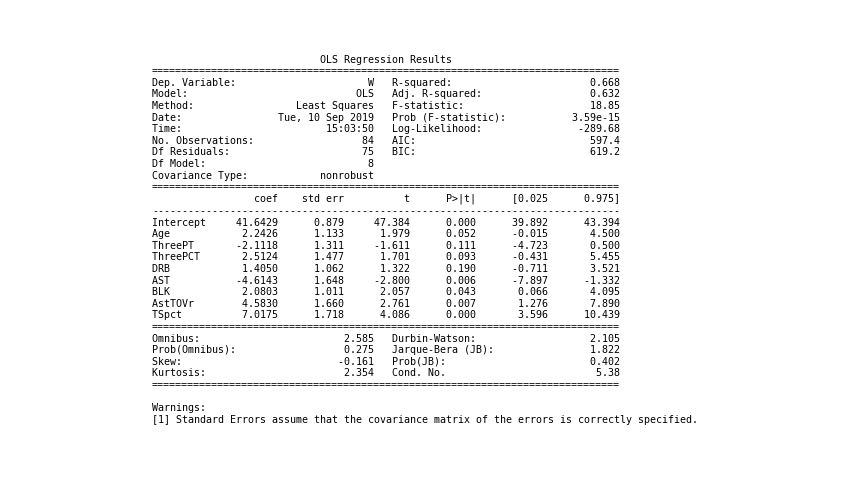

In [26]:
# call get_ols_sum() function to show/save OLS_lm summary as a figure
get_ols_sum(OLS_lm, 1)

**Hypothesis Test**
- **Null Hypothesis:** There is ***no*** relationship between the statistics &mdash; Age, ThreePT, ThreePCT, DRB, AST, BLK, AstTOVr, TSpct &mdash; and Wins.
    - &beta;<sub>n</sub> equals zero
- **Alternate Hypothesis:** There ***is*** a relationship between the statistics and Wins.
    - &beta;<sub>n</sub> *is not* equal to zero

**Testing Hypothesis**
- **Reject the null hypothesis:**
    - There *is* a relationship between the statistics &mdash; Age, ThreePT, ThreePCT, DRB, AST, BLK, AstTOVr, TSpct &mdash; and Wins.
    - If the 95% confidence interval ***does not*** include a zero
- **Fail to reject the null hypothesis:**
    - There is **no** relationship between the statistics
    - If the 95% confidence interval ***includes*** a zero

Take a look at the 95% confidence interval for each &beta;<sub>1</sub>, &beta;<sub>2</sub>, ... ,&beta;<sub>n</sub> value.

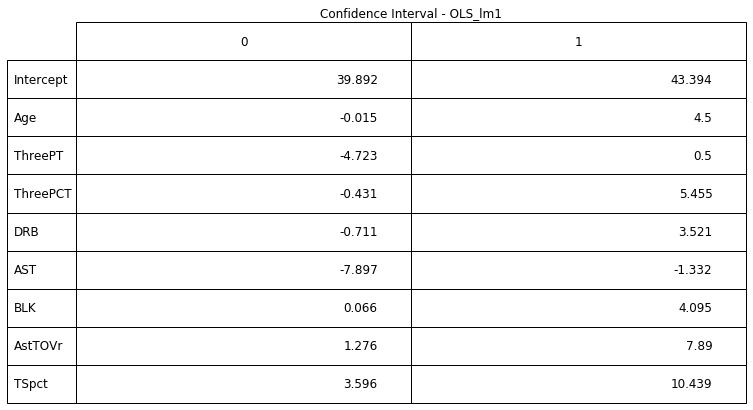

In [27]:
# call get_ols_conf() function to show/save OLS_lm confidence interval as a figure
get_olm_conf(OLS_lm, 1)

Looking at the confidence interval (above), we can see that Age, ThreePT, ThreePCT, DRB include a zero in their respective confidence interval.

**Take a look at the p-value**
- p-value < 0.05 are significant
    - Reject the null
    - There ***is*** a relationship
- p-value > 0.05 are not significant
    - Fail to reject the null
    - There is ***no*** relationship

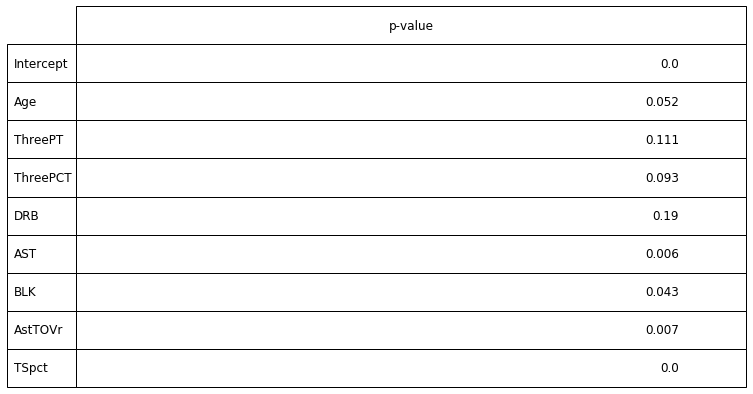

In [28]:
# call get_ols_pval() function to show/save OLS_lm p-value as a figure
get_ols_pval(OLS_lm, 1)

Looking at the p-value for each statistic (above), we can see that Age, ThreePT, ThreePCT, DRB have a p-value greater than 0.05.

Based on the information provided by the confidence interval and p-value for each statistic:
- Age, ThreePT, ThreePCT, DRB each have a zero in their respective confidence interval
- Age, ThreePT, ThreePCT, DRB each have a p-value > 0.05

Take a look at how well the model predicts the "unseen" out-of-sample test set.
- calculate **R-squared (R2)** and **Root Mean Square Error (RMSE)** to evaluate model prediction

In [29]:
# call get_rsquare_rmse() function to get rsquared and rmse
OLS_rsquare1, OLS_rmse1 = get_rsquare_rmse(OLS_lm, test_model_df, y_train, y_test)

# call show_rsquare_rmse() function to show values
show_rsquare_rmse(OLS_rsquare1, OLS_rmse1)

R-squared = 0.46014369914588094 
RMSE = 7.940265093048131


To see if we can improve on the model, let's refit the model by removing DRB since it has a zero in its confidence interval and the highest p-value, 0.19.

**Fit second OLS model with removal of DRB from features**

In [30]:
# fit second OLS regression model to data; remove DRB from features
OLS_lm2 = smf.ols(formula='W ~ Age + ThreePT + ThreePCT + AST + BLK + AstTOVr + TSpct', data=train_model_df).fit()

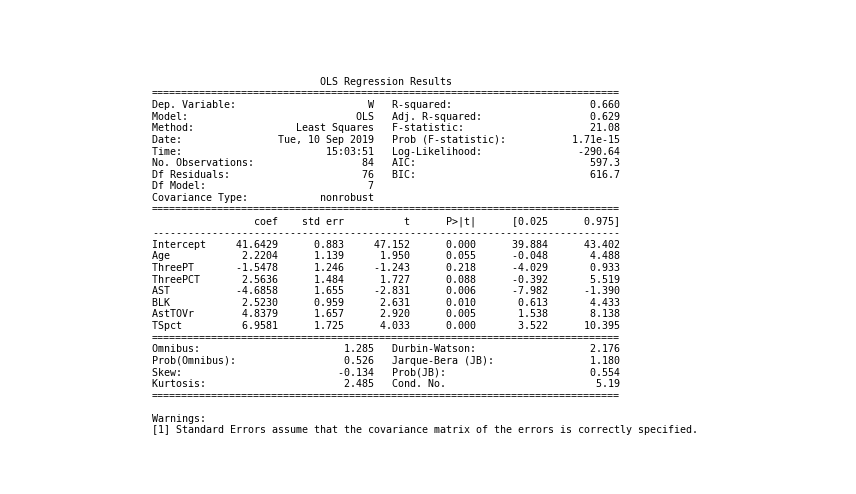

In [31]:
# call get_ols_sum() function to show/save OLS_lm summary as a figure
get_ols_sum(OLS_lm2, 2)

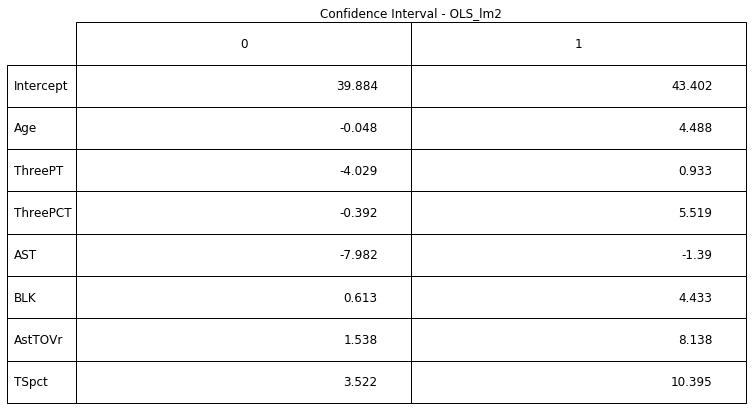

In [32]:
# call get_ols_conf() function to show/save OLS_lm confidence interval as a figure
get_olm_conf(OLS_lm2, 2)

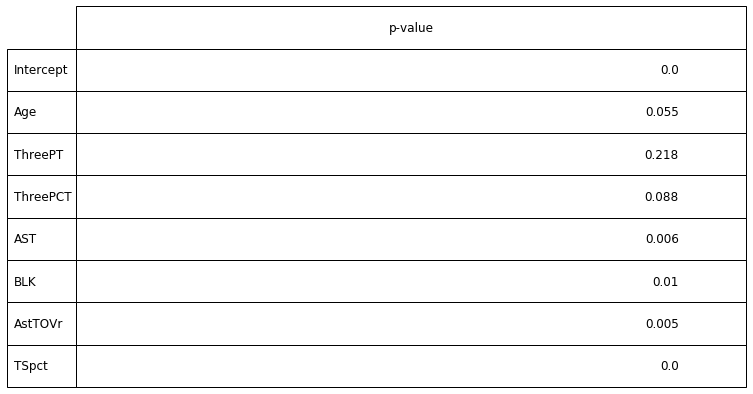

In [33]:
# call get_ols_pval() function to show/save OLS_lm p-value as a figure
get_ols_pval(OLS_lm2, 2)

Taking a look at the summary, confidence interval, p-value of the second OLS model, we can see the following:

**Confidence interval:**
- Age, ThreePT, ThreePCT have a confidence interval which includes a zero

**p-value:**
- Age, ThreePT, ThreePCT have a p-value > 0.05

Take a look at how well the second model predicts the "unseen" out-of-sample test set.
- calculate **R-squared (R2)** and **Root Mean Square Error (RMSE)** to evaluate model prediction

In [34]:
# call get_rsquare_rmse() function to get rsquared and rmse
OLS_rsquare2, OLS_rmse2 = get_rsquare_rmse(OLS_lm2, test_model_df, y_train, y_test)

# call show_rsquare_rmse() function to show values
show_rsquare_rmse(OLS_rsquare2, OLS_rmse2)

R-squared = 0.41237662144857257 
RMSE = 8.284102191242106


To see if we can improve on the model, let's refit the model by removing ThreePT since it has a zero in its confidence interval and the highest p-value, 0.218.

**Fit third OLS model with removal of ThreePT from features**

In [35]:
# fit third OLS regression model to data; remove ThreePT from features
OLS_lm3 = smf.ols(formula='W ~ Age + ThreePCT + AST + BLK + AstTOVr + TSpct', data=train_model_df).fit()

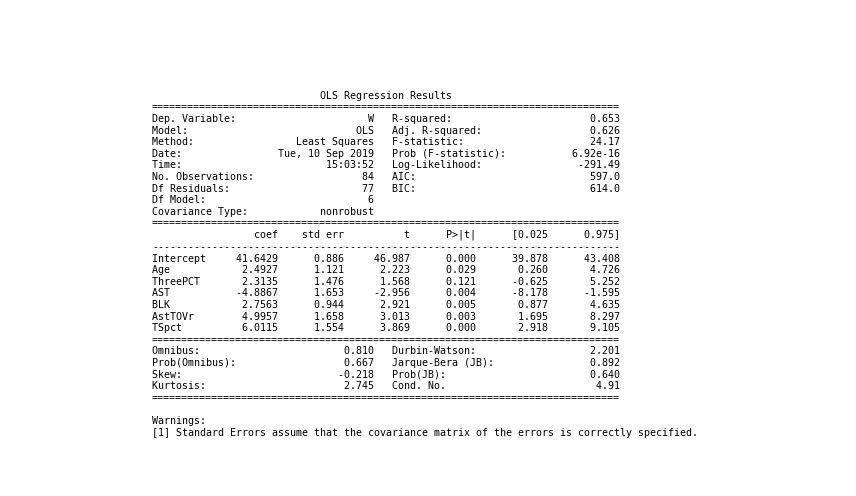

In [36]:
# call get_ols_sum() function to show/save OLS_lm summary as a figure
get_ols_sum(OLS_lm3, 3)

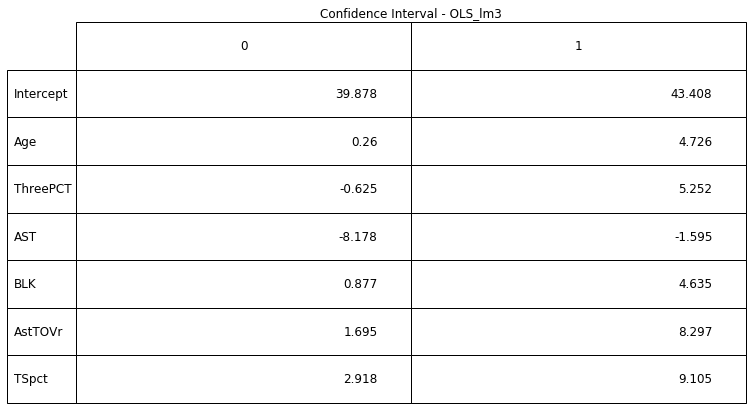

In [37]:
# call get_ols_conf() function to show/save OLS_lm confidence interval as a figure
get_olm_conf(OLS_lm3, 3)

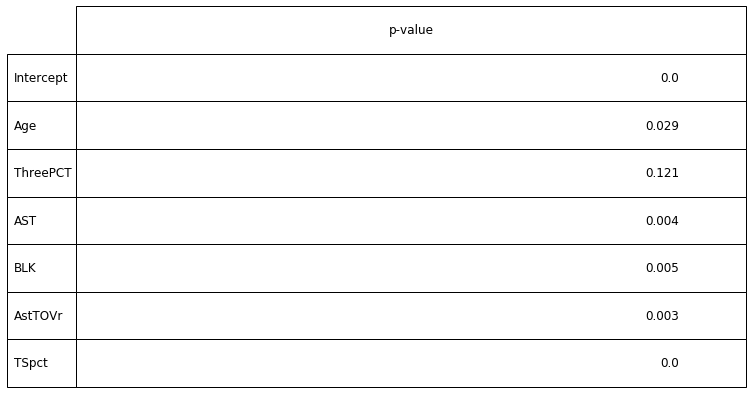

In [38]:
# call get_ols_pval() function to show/save OLS_lm p-value as a figure
get_ols_pval(OLS_lm3, 3)

Taking a look at the summary, confidence interval, p-value of the third OLS model, we can see the following:

**Confidence interval:**
- ThreePCT has a confidence interval which includes a zero

**p-value:**
- ThreePCT has a p-value > 0.05 

Take a look at how well the third model predicts the "unseen" out-of-sample test set.
- calculate **R-squared (R2)** and **Root Mean Square Error (RMSE)** to evaluate model prediction

In [39]:
# call get_rsquare_rmse() function to get rsquared and rmse
OLS_rsquare3, OLS_rmse3 = get_rsquare_rmse(OLS_lm3, test_model_df, y_train, y_test)

# call show_rsquare_rmse() function to show values
show_rsquare_rmse(OLS_rsquare3, OLS_rmse3)

R-squared = 0.4373785151125198 
RMSE = 8.10595280836828


To see if we can improve on the model, let's refit the model by removing ThreePCT since it has a zero in its confidence interval and the highest p-value, 0.121.

**Fit fourth OLS model with removal of ThreePCT from features**

In [40]:
# fit third OLS regression model to data; remove AST from features
OLS_lm4 = smf.ols(formula='W ~ Age + AST + BLK + AstTOVr + TSpct', data=train_model_df).fit()

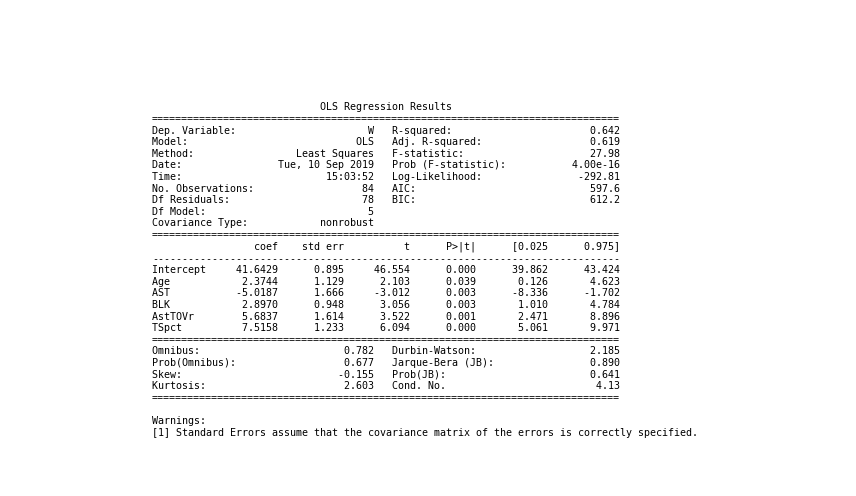

In [41]:
# call get_ols_sum() function to show/save OLS_lm summary as a figure
get_ols_sum(OLS_lm4, 4)

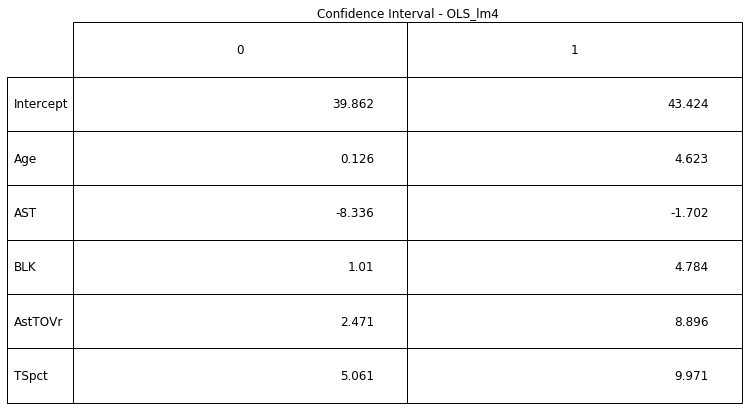

In [42]:
# call get_ols_conf() function to show/save OLS_lm confidence interval as a figure
get_olm_conf(OLS_lm4, 4)

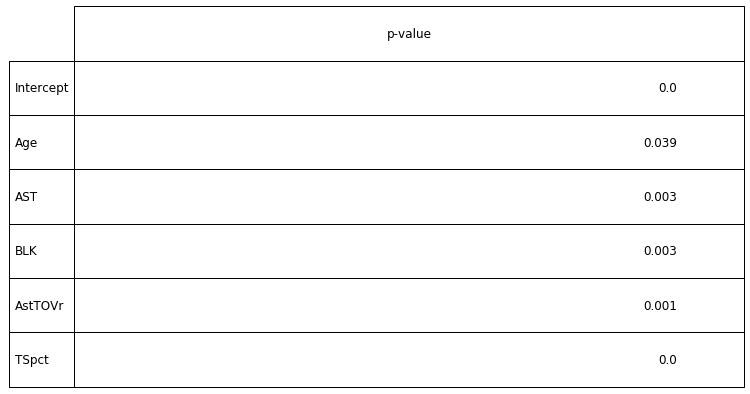

In [43]:
# call get_ols_pval() function to show/save OLS_lm p-value as a figure
get_ols_pval(OLS_lm4, 4)

Taking a look at the summary, confidence interval, p-value of the fourth OLS model, we can see the following:

**Confidence interval:**
- The remaining features &mdash; Age, AST, BLK, AstTOVr, TSpct &mdash; ***do not*** have a zero

**p-value:**
- The remaining features &mdash; Age, AST, BLK, AstTOVr, TSpct &mdash; have a p-value < 0.05

Interpreting the results from the fourth OLS model, we can ***reject the null hypothesis***; based on the information from the confidence interval and p-value, we can believe that there is a relationship between these statistics &mdash; Age, AST, BLK, AstTOVr, TSpct &mdash; and Wins.

Take a look at how well the fourth model predicts the "unseen" out-of-sample test set.
- calculate **R-squared (R2)** and **Root Mean Square Error (RMSE)** to evaluate model prediction

In [44]:
# call get_rsquare_rmse() function to get rsquared and rmse
OLS_rsquare4, OLS_rmse4 = get_rsquare_rmse(OLS_lm4, test_model_df, y_train, y_test)

# call show_rsquare_rmse() function to show values
show_rsquare_rmse(OLS_rsquare4, OLS_rmse4)

R-squared = 0.44973877552207664 
RMSE = 8.016418282740473


**Using the Scikit-Learn linear regression algorithm, build a regression model utilizing selected features for 2019 prediction.**

In [45]:
# using features selected from the final OLS_model_data dataframe, create X matrix & y vector data to perform sklearn linear regression
# features: Age, AST, BLK, AstTOVr, TSpct

# X & y for model training
X = train_model_df[['Age', 'AST', 'BLK', 'AstTOVr', 'TSpct']]
y = train_model_df['W']

# X for model testing
X_test2 = test_model_df[['Age', 'AST', 'BLK', 'AstTOVr', 'TSpct']]

In [46]:
# create an instance of LinearRegression object & train model
lm = LinearRegression()
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Below are functions returning information about the Scikit-Learn linear regression model, which helps analyze the model's performance.

In [47]:
def get_coeff(coeff_table, fig_num):
    """
    Create and save a figure of the Scikit-Learn linear model's coefficients.
    
    Takes a linear model's coefficient dataframe table and a model number to identify the model's coefficient table for .png file.  
    """
    # save Scikit-Learn lm coefficients as a figure
    axcoef = plt.subplot(frame_on=False)
    axcoef.xaxis.set_visible(False)
    axcoef.yaxis.set_visible(False)
    lm_coef_tb = tb(axcoef, coeff_table.round(3), loc='center', bbox=[0,0,1,1], colLabels=['Coefficients'])
    lm_coef_tb.auto_set_font_size(False)
    lm_coef_tb.set_fontsize(12)

    # plt.savefig('Scikit_lm_coeff'+str(fignum)+'.png')

In [48]:
def model_predict(model, x_data):
    """
    Run the Scikit-Learn linear model on the x-values to predict y-values.
    
    Takes a Scikit-Learn linear model and the x-values to predict the results of using the Scikit-Learn linear model.  
    """
    return model.predict(x_data)

In [49]:
def calc_sci_rmse(y_test_actual, y_lm_predicted):
    """
    Calculate and return the Scikit-Learn linear model Root Mean Square Error (RMSE).
    
    Takes the true outcome y-test values and the predicted y-values using the linear model.  
    """
    # measures standard deviation of residuals (i.e. prediction errors)
    return np.sqrt(metrics.mean_squared_error(y_test_actual, y_lm_predicted))

In [50]:
def calc_sci_rsquare(x_test_data, y_test_actual):
    """
    Calculate and return the Scikit-Learn linear model R-squared.
    
    Takes the x-test values to predict outcomes using linear model and true outcome y-test values.  
    """
    # measures "goodness of fit" - how close the data are to the regression line
    return lm.score(x_test_data, y_test_actual) # can also use metrics.r2_score(y_test_actual, y_lm_predicted)

Take a look at the results of the Scikit-Learn model.

In [51]:
# create table to view coefficient values
coeff_df = pd.DataFrame(data=lm.coef_, index=['Age', 'AST', 'BLK', 'AstTOVr', 'TSpct'], columns=['Coefficient'])

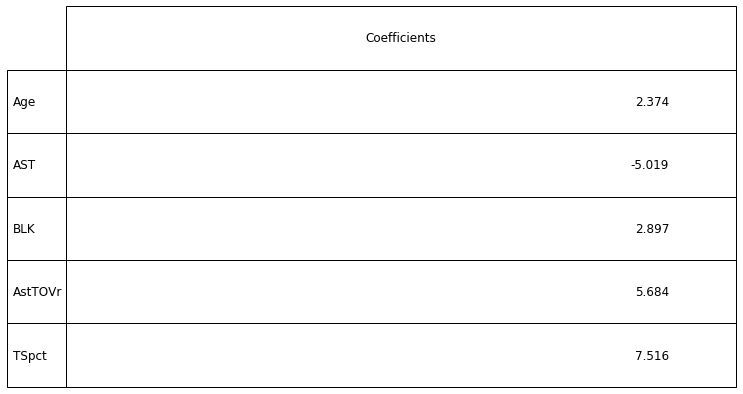

In [52]:
# call get_coeff() function to show/save table
get_coeff(coeff_df, 1)

In [53]:
# generate prediction values
y_pred = model_predict(lm, X_test2)

In [54]:
# create table to view actual vs predicted values
actual_v_pred = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
print(actual_v_pred.head())

    Actual  Predicted
17      36  52.925331
86      47  53.743958
68      17  25.945333
27      51  55.641300
84      41  27.063681


In [55]:
# call calc_sci_rmse() function to get Scikit Learn linear model RMSE value
print(calc_sci_rmse(y_test, y_pred))

8.016418282740476


Root Mean Squared Error (RMSE) value is 8.02 (~8); the fitted regression line has an approximate deviation of ~8 wins.

In [56]:
# call calc_sci_rsquare() function to get Scikit Learn linear model R-squared value
print(calc_sci_rsquare(X_test2, y_test))

0.42721796607605655


R-squared value shows that the fitted regression line accounts for 42.72% of the variance in the response data.

C:\Users\aliu4\Programs\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


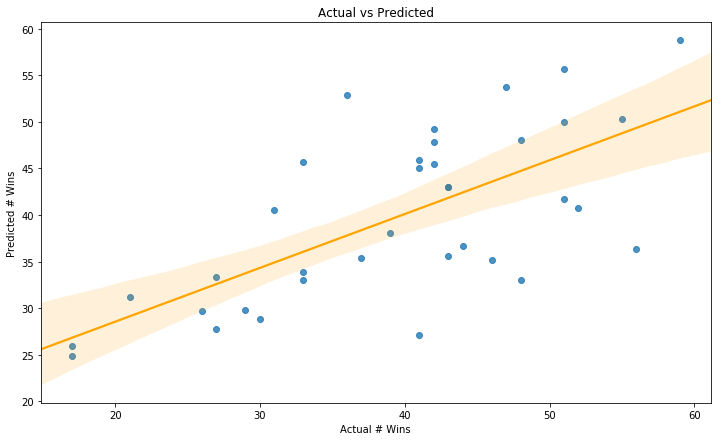

In [57]:
# visualize actual values vs predicted values; regression line includes a 0.95 confidence interval
sns.regplot(y_test.values, y_pred, line_kws={'color':'orange'})
plt.xlabel('Actual # Wins')
plt.ylabel('Predicted # Wins')
plt.title('Actual vs Predicted')

plt.show()

**Let's see how well the model can predict season performance in the 2019 NBA season.**

Organize and prepare the 2019 data similar to how the linear model data was prepared.

In [58]:
# Create dataframes for 2019 season
pred_X_data = pred_model_data[['Age', 'ThreePT', 'ThreePCT', 'DRB', 'AST', 'BLK', 'AstTOVr', 'TSpct']]
pred_y_data = pred_model_data['W']

In [59]:
# standardize 2019 X data for selected model prediction; utilize scale parameters performed on training data
stand_X_pred = scaler.transform(pred_X_data.values)

In [60]:
# convert standardized pred_X_data to dataframe; should have matrix shape same as selected linear model to predict values
pred_model_df = pd.DataFrame(stand_X_pred, index=pred_X_data.index, columns=['Age', 'ThreePT', 'ThreePCT', 'DRB', 'AST', 'BLK', 'AstTOVr', 'TSpct'])

Predict 2019 season performance with Scikit-Learn linear model features &mdash; Age, AST, BLK, AstTOVr, TSpct.

In [61]:
# create variable holding selected features; Age, AST, BLK, AstTOVr, TSpct
pred_X = pred_model_df[['Age', 'AST', 'BLK', 'AstTOVr', 'TSpct']]

In [62]:
# generate prediction values
lm_pred_val = model_predict(lm, pred_X)

In [63]:
# call calc_sci_rmse() function to get linear model RMSE value for 2019 data
print(calc_sci_rmse(pred_y_data, lm_pred_val))

9.087225144216074


Root Mean Squared Error (RMSE) value is 9.08 (~9); the fitted regression line has an approximate deviation of ~9 wins.

In [64]:
# call calc_sci_rsquare() function to get linear model R-squared value for 2019 data
print(calc_sci_rsquare(pred_X, pred_y_data))

0.4095972772521007


R-squared value shows that the fitted regression line accounts for 40.95% of the variance in the response data.

**Create a graph to visualize 2019 predicted values in comparison to actual**

To create the graphs:
- Adjust dataframe with standardized values to include Tm, W, Predicted Wins columns
- Establish Western and Eastern Conference NBA teams for playoff prediction evaluation

In [65]:
# Add-in columns for Tm, W, Predicted to dataframe with scaled values
pred_model_df.insert(0, 'Tm', pred_model_data['Tm'].values, True)
pred_model_df.insert(1, 'Actual_W', pred_y_data, True)
pred_model_df.insert(2, 'Predicted_W', lm_pred_val, True)

#take a look at dataframe head
pred_model_df.head()

,Tm,Actual_W,Predicted_W,Age,ThreePT,ThreePCT,DRB,AST,BLK,AstTOVr,TSpct
0,ATL,29,33.902926,-0.850578,2.108390,-0.158266,0.832303,1.474021,0.223145,-0.401918,0.441099
5,BOS,49,55.328324,-0.533967,1.878333,0.574049,1.043336,1.677986,0.468568,2.519352,1.024229
10,BRK,42,37.536973,-0.692273,1.976929,-0.101934,1.658849,0.569960,-1.003970,-0.046343,0.475029
15,CHO,39,52.624590,-0.059050,1.516814,-0.214598,0.419030,0.299844,0.008400,1.721602,0.374861
20,CHI,22,34.150517,-1.431032,-0.008138,-0.214598,0.603684,-0.301026,-0.819903,-0.218063,-0.264844


In [66]:
# create lists for western and eastern conferences 
west_conf = ['DAL','DEN','GSW','HOU','LAC','LAL','MEM','MIN','NOP','OKC','PHO','POR','SAC','SAS','UTA']
east_conf = ['ATL','BOS','BRK','CHO','CHI','CLE', 'DET','IND','MIA','MIL','NYK','ORL','PHI','TOR','WAS']

Below are functions to help streamline organizing and sorting of data for graph of model results.

In [67]:
def conf_list(dataframe, conf):
    """
    Create a list for each conference;
    returns a list of elements with the team name, actual win values, and predicted win values.
    
    Takes a dataframe and a conference name (i.e. west or east).
    """
    team_list = []

    for i in conf:
        for e, team in enumerate(dataframe['Tm']):
            if i == team:
                team_list.append([dataframe['Tm'].iloc[e], dataframe['Actual_W'].iloc[e], dataframe['Predicted_W'].iloc[e]])
                
    return team_list

In [68]:
def sort_actual_wins(conf_list):
    """
    Sort each conference list's actual wins, descending from greatest to lowest.
    
    Takes a conference list; west or east list of teams with team name, actual wins, and predicted wins.
    """
    # will be used to determine playoff teams
    return sorted(conf_list, key=lambda x:x[1], reverse=True)

def sort_predict_wins(conf_list):
    """
    Sort each conference list's predicted wins, descending from greatest to lowest.
    
    Takes a conference list; west or east list of teams with team name, actual wins, and predicted wins.
    """
    # will be used to determine playoff teams
    return sorted(conf_list, key=lambda x:x[2], reverse=True)

In [69]:
def get_actual_playoffs(sorted_w_list):
    """
    Determine which teams made it into the playoffs for actual win values;
    returns a sorted list of playoffs teams based on actual win records.
    
    Takes a conference's sorted actual win list; west or east list of teams with team name, actual wins, and predicted wins.
    """
    # only 8 teams from each conference qualify for the playoffs based on their win records in their respective conference
    playoffs_actual = []

    # append teams from actual wins that place into playoffs
    for i, team in enumerate(sorted_w_list):
        if sorted_w_list[i][1] >= sorted_w_list[7][1]: # checks each team against 8th place team
            playoffs_actual.append(team)
            
    return playoffs_actual

def get_predict_playoffs(sorted_p_list):
    """
    Determine which teams made it into the playoffs for predicted win values;
    returns a sorted list of playoffs teams based on predicted win records.
    
    Takes a conference's sorted predicted win list; west or east list of teams with team name, actual wins, and predicted wins.
    """
    # only 8 teams from each conference qualify for the playoffs based on their win records in their respective conference
    playoffs_predicted = []

    # append teams from predicted wins that place into playoffs
    for i, team in enumerate(sorted_p_list):
        if sorted_p_list[i][2] >= sorted_p_list[7][2]: # checks each team against 8th place team
            playoffs_predicted.append(team)
            
    return playoffs_predicted

In [70]:
def get_corr_incorr(actual_playoffs, predicted_playoffs):
    """
    Determine whether predictions were correct or incorrect in evaluating ability to qualify for playoffs;
    returns a list of correctly and incorrectly predicted teams.
    
    Takes a conference's actual and predicted playoff list; sorted west or east list of teams with team name, actual wins, and predicted wins.
    """
    corr_prediction = []
    incorr_prediction = []

    # append each conference teams from predictions into lists identifying correctly or incorrectly predicted
    for i, team in enumerate(predicted_playoffs):
        count = 0 # utilize counter to identify teams that do not match with any team in actual playoff list 
        for e, team2 in enumerate(actual_playoffs):
            if team[0] == team2[0]: # boolean check whether predicted playoff team matches with any team in actual playoff team list
                corr_prediction.append(team) 
            elif team[0] != team2[0]:
                count += 1
                if count == 8:
                    incorr_prediction.append(team)
                    
    return corr_prediction, incorr_prediction

In [71]:
def plot_corr_incorr(corr_playoffs, incorr_playoffs):
    """
    Plot color-code for correctly & incorrectly predicted playoff data points.
    
    Takes a list of correctly and incorrectly predicted playoff teams.
    """
    plt.plot([e for i,e,f in corr_playoffs], [f for i,e,f in corr_playoffs], 'go') # correct playoff predictions
    plt.plot([e for i,e,f in incorr_playoffs], [f for i,e,f in incorr_playoffs], 'ro') # incorrect playoff predictions

In [72]:
def annotate_labels(corr_playoffs, incorr_playoffs):
    """
    Annotate labels of team names for correctly & incorrectly predicted playoff teams.
    
    Takes a list of correctly and incorrectly predicted playoff teams.
    """
    # annotate team labels for predicted playoff teams to graph; label locations are fixed
    
    # annotates correctly predicted playoff teams
    for label, x, y in corr_playoffs:
        plt.annotate(s=label, xy=(x,y), xytext=(-2,8), textcoords='offset points')
    
    # annotates incorrectly predicted playoff teams
    for label, x, y in incorr_playoffs:
        plt.annotate(s=label, xy=(x,y), xytext=(-2,8), textcoords='offset points')

In [73]:
def show_predict_playoffs(y_actual, y_predict, west_c, west_i, east_c, east_i):
    """
    Plot graph of all NBA teams based on actual vs predicted wins;
    include annotated labels and color-coding of team names for correctly & incorrectly predicted playoff teams.
    
    Takes the true outcome y-win values, predicted y-win values, 
    a list of correctly and incorrectly predicted playoff teams for each conference.
    """
    # create graph to help visualize actual vs predicted values; correct vs incorrect playoff predictions

    # plot data to graph
    plt.scatter(y_actual, y_predict) # actual vs predicted win values

    # call plot_corr_incorr() function to plot data points for correctly & incorrectly predicted playoff teams; color-coded data points
    plot_corr_incorr(west_c, west_i) # plot correct & incorrect playoff predicted teams for western conference
    plot_corr_incorr(east_c, east_i) # plot correct & incorrect playoff predicted teams for eastern conference

    # generate "y=mx+b" values to plot best-fit line
    y_slope, y_int = np.polyfit(y_actual, y_predict, 1)
    plt.plot(y_actual, y_slope*y_actual+y_int, '-y')

    # call annotate_labels() function to annotate team names for predicted playoff teams to graph
    annotate_labels(west_c, west_i)
    annotate_labels(east_c, east_i)

    plt.xlabel('Actual # Wins')
    plt.ylabel('Predicted # Wins')
    plt.title('Predicted Playoff Teams')

    # adjust graph paramaters
    plt.xlim(right=65)
    plt.ylim(top=70)

    # create legend
    pred_incorr = mpatches.Patch(color='red', label='Incorrect Playoff Predictions')
    pred_corr = mpatches.Patch(color='green', label='Correct Playoff Predictions')

    plt.legend(loc='upper left', handles=[pred_incorr, pred_corr])

    plt.show()

    # plt.savefig('scatter_pred_18-19.png')

Prepare and create graph of Scikit-Learn model results.

In [74]:
# call conf_list() function to get western and eastern conference lists
# returns a list of each team with team name, actual wins, predicted wins
west_list = conf_list(pred_model_df, west_conf)
east_list = conf_list(pred_model_df, east_conf)

In [75]:
# call sort_actual_wins() & sort_predict_wins() functions to sort each conference actual wins and predicted wins
# sort lists by actual wins
west_W_sorted = sort_actual_wins(west_list)
east_W_sorted = sort_actual_wins(east_list)

# sort lists by predicted wins
west_P_sorted = sort_predict_wins(west_list)
east_P_sorted = sort_predict_wins(east_list)

In [76]:
# call get_actual_playoffs() & get_predict_playoff() functions to determine playoff teams for each conference using actual wins vs predicted wins
# get actual playoff teams
west_playoffs_actual = get_actual_playoffs(west_W_sorted)
east_playoffs_actual = get_actual_playoffs(east_W_sorted)
                                           
# get predicted playoff teams
west_playoffs_pred = get_predict_playoffs(west_P_sorted)
east_playoffs_pred = get_predict_playoffs(east_P_sorted)

In [77]:
# call get_corr_incorr() function to get west and east correct vs incorrect playoff predictions
west_corr, west_incorr = get_corr_incorr(west_playoffs_actual, west_playoffs_pred)
east_corr, east_incorr = get_corr_incorr(east_playoffs_actual, east_playoffs_pred)

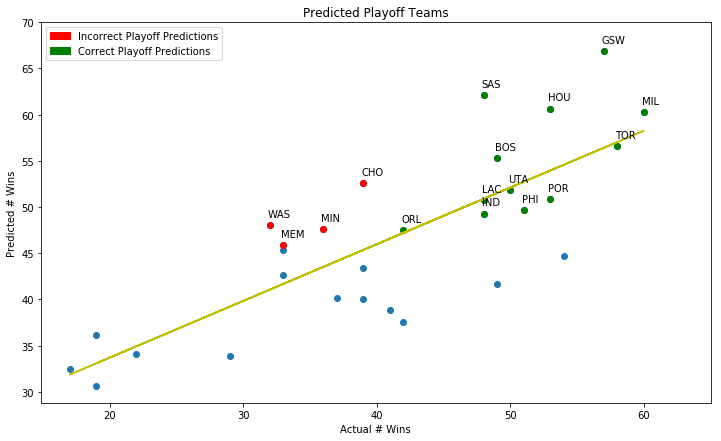

In [78]:
# call show_predict_playoffs() function to get predicted playoff teams graph
# incorrectly predicted teams are highlighted in red; correctly predicted teams are highlighted in green
show_predict_playoffs(pred_y_data, lm_pred_val, west_corr, west_incorr, east_corr, east_incorr)

Use code below to manually recoordinate location of select data point team labels.

In [79]:
# # create graph to help visualize actual vs predicted values; correct vs incorrect playoff predictions

# # plot data to graph
# plt.scatter(pred_y_data, lm_pred_val) # actual vs predicted win values

# # call plot_corr_incorr() function to plot data points for correctly & incorrectly predicted playoff teams; color-coded data points
# plot_corr_incorr(west_corr, west_incorr) # plot correct & incorrect playoff predicted teams for western conference
# plot_corr_incorr(east_corr, east_incorr) # plot correct & incorrect playoff predicted teams for eastern conference

# # generate "y=mx+b" values to plot best-fit line
# y_slope, y_int = np.polyfit(pred_y_data, lm_pred_val, 1)
# plt.plot(pred_y_data, y_slope*pred_y_data+y_int, '-y')

# # annotate team labels for predicted playoff teams to graph; adjust location of label as needed
# for label, x, y in east_incorr:
#     if label == 'WAS':
#         plt.annotate(s=label, xy=(x,y), xytext=(-20,8), textcoords='offset points')
#     else:
#         plt.annotate(s=label, xy=(x,y), xytext=(-2,8), textcoords='offset points')
# for label, x, y in west_incorr:
#     if label == 'MEM':
#         plt.annotate(s=label, xy=(x,y), xytext=(5,-8), textcoords='offset points')
#     else:
#         plt.annotate(s=label, xy=(x,y), xytext=(-2,8), textcoords='offset points')
# for label, x, y in east_corr:
#     if label == 'TOR':
#         plt.annotate(s=label, xy=(x,y), xytext=(5,0), textcoords='offset points')
#     elif label == 'IND':
#         plt.annotate(s=label, xy=(x,y), xytext=(-10,-15), textcoords='offset points')
#     elif label == 'PHI':
#         plt.annotate(s=label, xy=(x,y), xytext=(0,-15), textcoords='offset points')
#     else:
#         plt.annotate(s=label, xy=(x,y), xytext=(-2,8), textcoords='offset points')
# for label, x, y in west_corr:
#     if label == 'LAC':
#         plt.annotate(s=label, xy=(x,y), xytext=(-10,8), textcoords='offset points')
#     elif label == 'POR':
#         plt.annotate(s=label, xy=(x,y), xytext=(2,8), textcoords='offset points')
#     else:
#         plt.annotate(s=label, xy=(x,y), xytext=(-2,8), textcoords='offset points')

# plt.xlabel('Actual # Wins')
# plt.ylabel('Predicted # Wins')
# plt.title('Predicted Playoff Teams')
        
# # adjust graph paramaters
# plt.xlim(right=65)
# plt.ylim(top=70)

# # create legend
# pred_incorr = mpatches.Patch(color='red', label='Incorrect Playoff Predictions')
# pred_corr = mpatches.Patch(color='green', label='Correct Playoff Predictions')

# plt.legend(loc='upper left', handles=[pred_incorr, pred_corr])

# plt.show()

# # plt.savefig('scatter_pred_18-19.png')

From the graph above, we can see that there are 4 teams that the linear model did not correctly predict the results of making it into the playoffs.

Incorrectly predicted teams: Charlotte Hornets (CHO), Washington Wizards (WAS), Minnesota Timberwolves (MIN), Memphis Grizzlies (MEM).

**Create a table for each conference to help identify incorrectly predicted playoff teams vs actual playoff teams**

In [80]:
# import imgkit tool for html to other file type (e.g. png, pdf, etc.) conversion
import imgkit

In [81]:
# create path to wkhtmltopdf tool so that imgkit tool can convert html object
path_wkhtmltoimage = r'C:\Users\aliu4\Programs\Anaconda3\wkhtmltopdf\bin\wkhtmltoimage.exe'
config_img = imgkit.config(wkhtmltoimage=path_wkhtmltoimage)

Below are functions to streamline organizing and sorting of data for creation of Scikit-Learn's model results of playoff teams.

In [82]:
# function to merge each conference actual & predicted playoff teams
def merge_df(actual_playoffs, predicted_playoffs, conf_string):
    """
    Convert a list of playoff teams to a dataframe and merge the dataframe of each conference actual & predicted playoff teams, 
    and reset index to start at 1; new index refers to playoff standings. Returns a dataframe with actual and predicted playoff teams from each conference.
    
    Takes a list of the actual and predicted playoff teams,
    and a string of the conference name.
    """
    # create new dataframes with each conference playoff teams
    # will return dataframe table with actual & predicted playoffs for comparison
    df = pd.merge(pd.DataFrame(actual_playoffs, 
                               columns=[conf_string.lower().capitalize()+'_Tm_Actual', 
                                        conf_string.lower().capitalize()+'_Actual_W', 'Predicted_W']).drop('Predicted_W', axis=1), 
                  pd.DataFrame(predicted_playoffs, 
                               columns=[conf_string.lower().capitalize()+'_Tm_Pred', 'Actual_W', 
                                        conf_string.lower().capitalize()+'_Pred_W']).drop('Actual_W', axis=1), left_index=True, right_index=True)
    
    # round predicted values
    df[conf_string.lower().capitalize()+'_Pred_W'] = np.round(df[conf_string.lower().capitalize()+'_Pred_W'])

    # convert predicted values from float to integer
    df[conf_string.lower().capitalize()+'_Pred_W'] = df[conf_string.lower().capitalize()+'_Pred_W'].astype('int64')

    # adjust index to start with 1 to show which playoff teams #1-#8
    df.index += 1
    
    return df

In [83]:
def color_df(dataframe, conf_string):
    """
    Color incorrectly predicted playoff team(s) red.
    
    Takes dataframe with actual and predicted playoff teams,
    and a string of the conference name.
    """
    def get_color(val):
        return ['color:red' if v not in list(dataframe[conf_string.lower().capitalize()+'_Tm_Actual']) else 'color: black' for v in dataframe[conf_string.lower().capitalize()+'_Tm_Pred']]
    return get_color

def color_df2(dataframe, conf_string):
    """
    Color actual playoff team(s) darkorange;
    specifically teams that should have been predicted as playoff teams.
    
    Takes dataframe with actual and predicted playoff teams,
    and a string of the conference name.
    """
    def get_color2(val):
        return ['color:darkorange' if v not in list(dataframe[conf_string.lower().capitalize()+'_Tm_Pred']) else 'color: black' for v in dataframe[conf_string.lower().capitalize()+'_Tm_Actual']]
    return get_color2

In [84]:
def set_tb_props(df_tb):
    """
    Set table properties.
    
    Takes a dataframe table to be formatted.
    """
    # set table properties
    df_tb.set_properties(**{'border-collapse':'collapse'})

    # set table styles
    df_tb.set_table_styles([{'selector':' ', 'props':[('border-collapse','collapse'),('border-bottom','1px solid black'),('border-left', '1px solid black'),('border-right', '1px solid black'),('border-top', '1px solid black')]}\
                            ,{'selector':'th', 'props':[('text-align','center'),('border-bottom','1px solid black'),('border-left', '1px solid black'),('border-right', '1px solid black'),('border-top', '1px solid black')]}\
                            ,{'selector':'td', 'props':[('text-align','center'),('border-bottom','1px solid black'),('border-left', '1px solid black'),('border-right', '1px solid black'),('border-top', '1px solid black')]}])

In [85]:
def get_table(dataframe, conf_string):
    """
    Create dataframe table with highlighted incorrectly predicted vs actual playoff teams using css html formatting;
    returns a formatted dataframe table.
    
    Takes a dataframe with actual and predicted playoff teams, 
    and a string of the conference name.
    """
    # create a styler object with colored text of incorrectly predicted playoff teams vs actual teams
    df_tb = dataframe.style.apply(color_df2(dataframe, conf_string), subset=[conf_string.lower().capitalize()+'_Tm_Actual'])\
                            .apply(color_df(dataframe, conf_string), subset=[conf_string.lower().capitalize()+'_Tm_Pred'])
    
    # set table properties
    df_tb.set_properties(**{'border-collapse':'collapse'})

    # set table styles
    df_tb.set_table_styles([{'selector':' ', 'props':[('border-collapse','collapse'),('border-bottom','1px solid black'),('border-left', '1px solid black'),('border-right', '1px solid black'),('border-top', '1px solid black')]}\
                            ,{'selector':'th', 'props':[('text-align','center'),('border-bottom','1px solid black'),('border-left', '1px solid black'),('border-right', '1px solid black'),('border-top', '1px solid black')]}\
                            ,{'selector':'td', 'props':[('text-align','center'),('border-bottom','1px solid black'),('border-left', '1px solid black'),('border-right', '1px solid black'),('border-top', '1px solid black')]}])
    
    return df_tb

In [86]:
def render_tb(df_tb, conf_string):
    """
    Render a dataframe table to html and save the formatted table to a .png file;
    saves an image of the dataframe table to directory.
    
    Takes a dataframe table with actual and predicted playoff teams, 
    and a string of the conference name.
    """
    # render west_df_tb to html
    html = df_tb.render()
    
    # convert and save to png file
    return imgkit.from_string(html, conf_string.lower().capitalize()+'_Playoffs_TB.png', config=config_img)

In [87]:
# function to combine west & east dataframe tables, and apply table formatting style
# includes highlighting of incorrectly predicted playoff teams vs actual playoff teams
def get_west_east(west, east, west_string, east_string):
    """
    Combine west & east dataframe tables, and apply table formatting style;
    returns a table with highlighting of incorrectly predicted playoff teams vs actual playoff teams.
    
    Takes a dataframe table of each conference, and a string of each conference name.
    """
    # combine west and east dataframes
    combined_df = pd.merge(west, east, left_index=True, right_index=True)
    
    # create a styler object with colored text of incorrectly predicted playoff teams vs actual teams
    combined_tb = combined_df.style.apply(color_df2(east, east_string), subset=[east_string.lower().capitalize()+'_Tm_Actual'])\
                            .apply(color_df(east, east_string), subset=[east_string.lower().capitalize()+'_Tm_Pred'])\
                            .apply(color_df2(west, west_string), subset=[west_string.lower().capitalize()+'_Tm_Actual'])\
                            .apply(color_df(west, west_string), subset=[west_string.lower().capitalize()+'_Tm_Pred'])
    
    set_tb_props(combined_tb)
    
    return combined_tb

 Observations of tables:
- Season performance (wins) results of actual vs. predicted playoff teams
- Which teams were the actual playoff teams in relation to the incorrectly predicted playoff teams

In [88]:
# call merge_df() function to get dataframe tables with each conference actual vs predicted playoff teams
west_df = merge_df(west_playoffs_actual, west_playoffs_pred, 'west')
east_df = merge_df(east_playoffs_actual, east_playoffs_pred, 'east')

**West playoffs teams**

In [89]:
# call get_table() function to get table
west_df_tb = get_table(dataframe=west_df, conf_string='west')

# show west_df_tb
west_df_tb

,West_Tm_Actual,West_Actual_W,West_Tm_Pred,West_Pred_W
1,GSW,57,GSW,67
2,DEN,54,SAS,62
3,HOU,53,HOU,61
4,POR,53,UTA,52
5,UTA,50,POR,51
6,OKC,49,LAC,51
7,LAC,48,MIN,48
8,SAS,48,MEM,46


In [90]:
# call render_tb() function to convert & save dataframe table to .png file
render_tb(west_df_tb, 'west')

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

**East playoffs teams**

In [91]:
# call get_table() function to get table
east_df_tb = get_table(dataframe=east_df, conf_string='east')

# show east_df_tb
east_df_tb

,East_Tm_Actual,East_Actual_W,East_Tm_Pred,East_Pred_W
1,MIL,60,MIL,60
2,TOR,58,TOR,57
3,PHI,51,BOS,55
4,BOS,49,CHO,53
5,IND,48,PHI,50
6,BRK,42,IND,49
7,ORL,42,WAS,48
8,DET,41,ORL,48


In [92]:
# call render_tb() function to convert & save dataframe table to .png file
render_tb(east_df_tb, 'east')

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True

Combine West and East dataframes tables with highlighting of incorrect playoff team predictions vs actual playoff teams that should be in place of incorrect predictions.

In [93]:
# call get_west_east() function to combine new dataframe table
combined_tb = get_west_east(west_df, east_df, 'west','east')

# show west_east_tb
combined_tb

,West_Tm_Actual,West_Actual_W,West_Tm_Pred,West_Pred_W,East_Tm_Actual,East_Actual_W,East_Tm_Pred,East_Pred_W
1,GSW,57,GSW,67,MIL,60,MIL,60
2,DEN,54,SAS,62,TOR,58,TOR,57
3,HOU,53,HOU,61,PHI,51,BOS,55
4,POR,53,UTA,52,BOS,49,CHO,53
5,UTA,50,POR,51,IND,48,PHI,50
6,OKC,49,LAC,51,BRK,42,IND,49
7,LAC,48,MIN,48,ORL,42,WAS,48
8,SAS,48,MEM,46,DET,41,ORL,48


We can see from the table above that the model correctly predicted 12 of the 16 playoff teams. However, the model did not predict wins values well at all and was only able to accurately predict the playoff standing (i.e. playoff position ranking) of 4 teams &mdash; Golden State Warriors (GSW), Houston Rockets (HOU), Milwaukee Bucks (MIL), Toronto Raptors (TOR).

In [94]:
# call render_tb() function to convert & save dataframe table to .png file
render_tb(combined_tb, 'west_east')

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


True